# BUSA - 8001 - Final Group Assignment 

**Acknoledgment:**

The [Ames Housing](http://jse.amstat.org/v19n3/decock.pdf) dataset was compiled by Dean De Cock for use in data science education. It's an incredible alternative for data scientists looking for a modernized and expanded version of the often cited Boston Housing dataset. 

**References**
 - http://jse.amstat.org/v19n3/decock.pdf

**Assignment By:**
 - Nitin Reddy Goli - 45675139
 - Samara Simha Reddy Vallem - 46151796
 - Angel Abraham Angel Abraham - 46131582


# Part - 1 Kaggle Paper Review and Problem Description

## OVERVIEW:

Real Estate is one of the most competitive market, where every agent and client aims for a good deal price based on the various factors of the house. The goal of our project is to predict the sales price of properties in Ames, Iowa based on the basic concepts on data collected for housing prices. 

**DATASET & FORECASTING PROBLEMS:**

The data consists 1460 observations with 80 explanatory variables which describes about the sales price (dependent variable) over a span of 4 years from 2006 to 2010. These variables reflect various aspects which will influence the sales price of the houses directly. Potential clients would review the house based on these aspects. These variables are typically divided into categories like continuous, categorical and target variables.

Forecasting Problems:
- Execution Time for hyperparameter tuning
- Dealing with outliers
- Data is not normally distributed

Following is our workflow:

-	Data Exploration
-	Analysing: Univariant and Bivariant Analysis
-	Selecting: Optimal Model
-	Testing: Optimal Model
-	Comparing: SVR, Decision Tree, Stacking, LGBR, Random Forest


**EVALUATION CRITERIA:**

The actual sales price (Y) which is missing in the test data is compared with the predicted sales prices obtained from the model. 

   -            Mean Square Error: Difference between the actual sales price and predicted sales price helps us understand how concentrated data is to the best line of fit.

The linear correlation graph explains the variations in sales price. The residual is the difference between the Actual Price and Predicted Price. If the residual is larger than the model is predicted inefficiently.


**DATASET & RELEVANT FEATURES:**

The data consists of missing values. This can be filled by grouping them based on its relations. We can try to either eliminate the variables which are not needed by adding small error term, while we can also construct additional features by transforming original variables. As our dataset is already small, we will not be deleting any variables. We will be using two models Lasso and sklearn’s permutation to find feature importance and expect existing features like overall quality, neighbourhood and other. We will use variables that are not related to each other to construct relevant variables. We can try to fill the missing values of categorical variables with their mode and numerical variables with their mean. We can also transform the highly skewed variables using yeo-Johnson transformation.


**ANTICIPATED ISSUES/COMPLICATIONS:**

Choosing an accurate model to predict will possess as a major challenge as there are n-number of models to choose from like SVR, Decision Tree, LGBR, Random Forest and Stacking. And one of the other major challenges is feature transformation because choosing inappropriate existing features to create new features will create variables that effectively do not correlate with the dependent variable. 


# Part - 2 Data Cleaning, Missing Observations and Feature Engineering


**Import Libraries**

In [96]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import missingno as msno
from sklearn.metrics import mean_squared_error
import numpy as np  
import pandas as pd  

pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 100)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

from sklearn.inspection import permutation_importance
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as mticker
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
import math
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt
import seaborn as sns

import gc

gc.enable() #Enable automatic garbage collection.

from bokeh.io import output_notebook, show
from bokeh.models import (
    BasicTicker,
    ColorBar,
    ColumnDataSource,
    LinearColorMapper,
    PrintfTickFormatter,
)
from bokeh.plotting import figure
from bokeh.transform import transform


random_state = 55

In [134]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(f"Train: Rows - {train.shape[0]}, Columns - {train.shape[1]}.")
print(f"Test: Rows - {test.shape[0]}, Columns - {test.shape[1]}.")
print(f'{set(train.columns) - set(test.columns) } is missing in test dataset but exists in train, hence the difference in columns.')

Train: Rows - 1460, Columns - 81.
Test: Rows - 1459, Columns - 80.
{'SalePrice'} is missing in test dataset but exists in train, hence the difference in columns.


In [136]:
print(train.info())
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [102]:
# Extrating Id column from test data as it will be used at the time of subbmission.  
Id_submission = test.loc[:,'Id']

# Dropping Id from both our dataframes 
train = train.drop('Id', axis = 1)
test = test.drop('Id', axis = 1)

# Instanciating all salesprice's to 0 in test df as this coloum doesnt exist in the test df and will result in NA when combained with train.
test['SalePrice'] = 0

train.loc[:, "Train"] = 1
test.loc[:, "Train"] = 0

# Piled_df is a dataframe where train and test df's are stacked on top of each other.

piled_df = pd.concat([train,test], ignore_index= True)
print(f"Piled_df : Rows - {piled_df.shape[0]}, Columns - {piled_df.shape[1]}.")

Piled_df : Rows - 2919, Columns - 81.


# Univarient Analysis of Target Variable

Doing the analysis by plotting two graphs as follows:
1. SalePrice Againts Count - Shows the actual distribution of our target variable.
2. Log transformed SalePrice - Shows how are actual distrubition changes. 


Text(0.5, 1.0, 'Distribution of SalePrice (Log Transformed)')

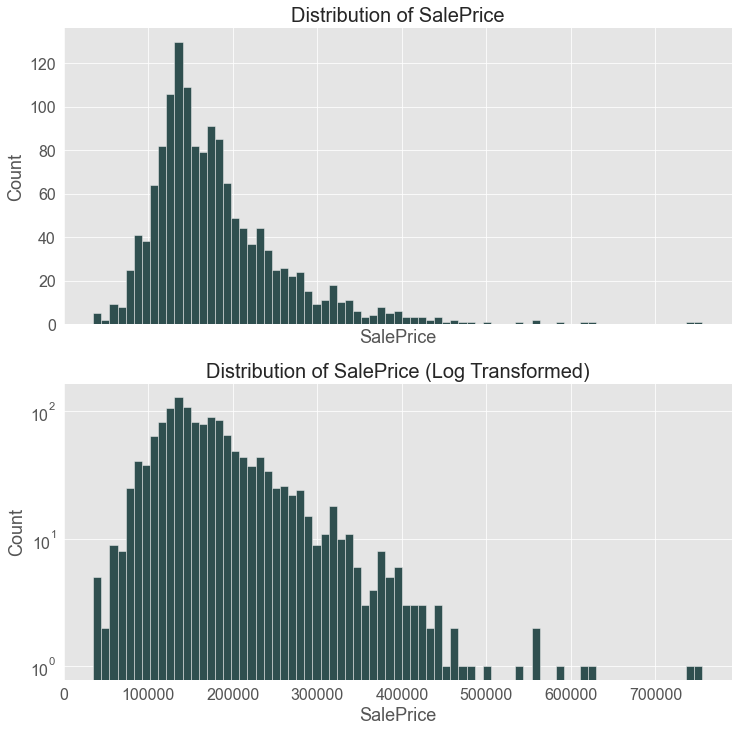

In [103]:
plt.style.use('ggplot')
params = {
    "axes.labelsize": 18,
    "axes.titlesize": 20,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
}
plt.rcParams.update(params)

(fig, ax) = plt.subplots(nrows=2, ncols=1, figsize=[12, 12], sharex=True)

ax[0].set_xlabel("SalePrice")
ax[0].set_ylabel("Count")

ax[1].set_xlabel("SalePrice")
ax[1].set_ylabel("Count")

plot_X = piled_df.loc[piled_df["Train"] == 1]["SalePrice"]

plot = ax[0].hist(plot_X, bins=75, log=False, color="darkslategrey")
plot = ax[1].hist(plot_X, bins=75, log=True, color="darkslategrey")

ax[0].set_title("Distribution of SalePrice")
ax[1].set_title("Distribution of SalePrice (Log Transformed)")

# Bivariant Analysis:

 - Few numerical features are plotted against our dependent feature through Scatter Plot. 
 - Catogrical features are plotted against our depedent variable using Box Plot. 

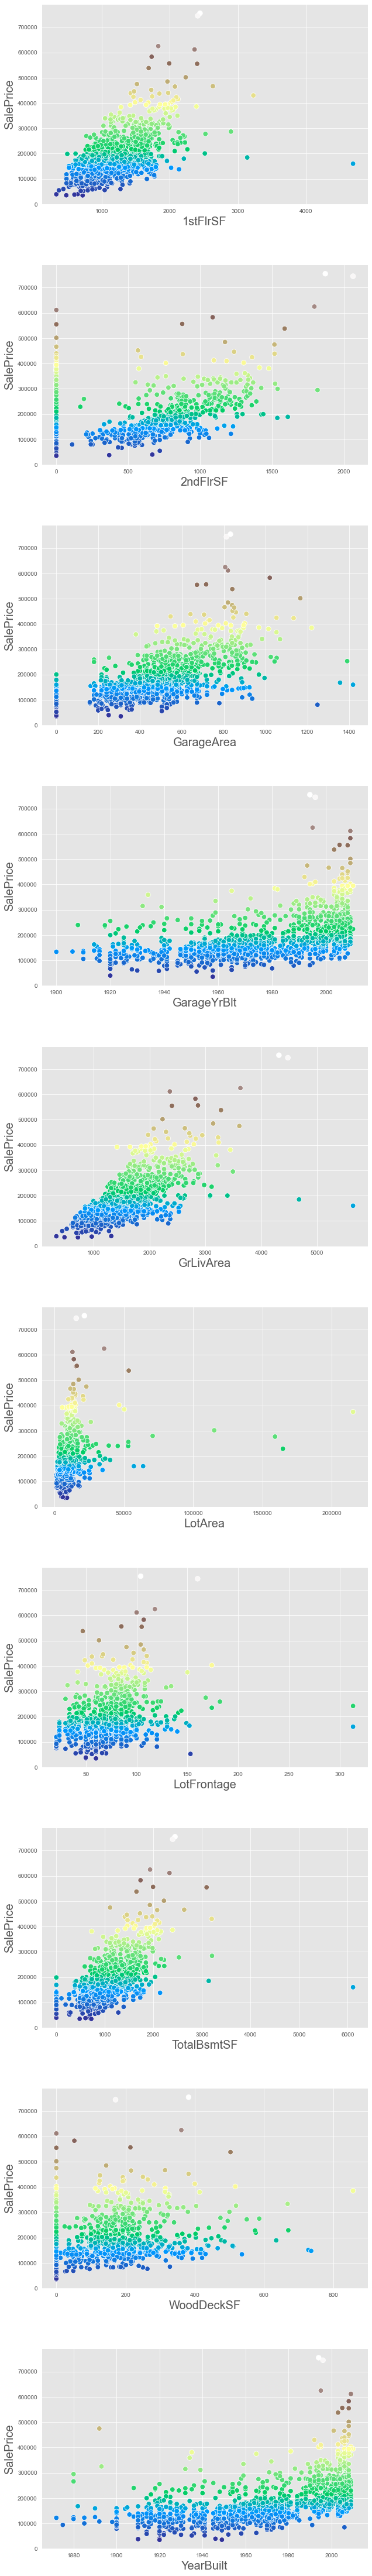

In [104]:
para_m = {"axes.labelsize": 20, 
          "xtick.labelsize": 10, 
          "ytick.labelsize": 10}
plt.rcParams.update(para_m)

features_to_viz = [
    "GrLivArea",
    "YearBuilt",
    "WoodDeckSF",
    "LotArea",
    "GarageArea",
    "1stFlrSF",
    "2ndFlrSF",
    "TotalBsmtSF",
    "LotFrontage",
    "GarageYrBlt",
]

# Because there are a lot of variables to vizualize,
# sorting them helps me keep track of which variable is where

features_to_viz = sorted(features_to_viz)

ncols = 1
nrows = math.ceil(len(features_to_viz) / ncols)
unused = nrows * ncols - len(features_to_viz)

figw = ncols * 10
figh = nrows * 8

(fig, ax) = plt.subplots(nrows, ncols, sharey=True, figsize=(figw, figh))
fig.subplots_adjust(hspace=0.3)
ax = ax.flatten()

for i in range(unused, 0, -1):
    fig.delaxes(ax[-i])

for (n, col) in enumerate(features_to_viz):
    if n % 2 != 0:
        ax[n].yaxis.label.set_visible(False)
    ax[n].set_xlabel(col)
    ax[n].set_ylabel("SalePrice")
    sns.scatterplot(
        x=col,
        y="SalePrice",
        data=piled_df.loc[piled_df["Train"] == 1],
        hue="SalePrice",
        palette="terrain",
        s=75,
        legend=False,
        ax=ax[n],
    )

plt.show()


**Findings:**
 - There are a few features that represent a linear like relationship with the depedent variables. For example: GrLive Area, 1stFlrSF, TotalBsmtSF are a few.
 - It is very apparent that there are outliers in our dataframe. Instead of directly deleting these outliers we can make use of them because the data provided is quite limited. 
 
 
 
# Box Plots on Catagorical Features 

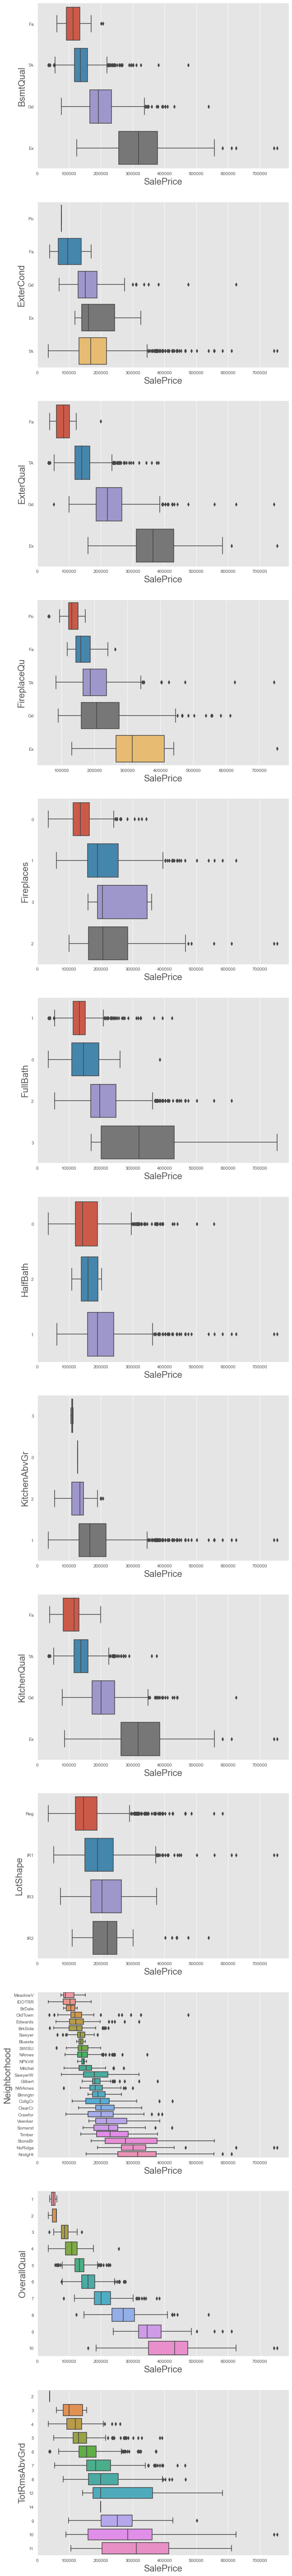

In [105]:
features_to_viz = [
    "Neighborhood",
    "BsmtQual",
    "ExterQual",
    "FireplaceQu",
    "ExterCond",
    "KitchenQual",
    "LotShape",
    "OverallQual",
    "FullBath",
    "HalfBath",
    "TotRmsAbvGrd",
    "Fireplaces",
    "KitchenAbvGr",
]


features_to_viz = sorted(features_to_viz)

ncols = 1
nrows = math.ceil(len(features_to_viz) / ncols)
unused = nrows * ncols - len(features_to_viz)

(figw, figh) = (ncols * 10, nrows * 8)

(fig, ax) = plt.subplots(nrows, ncols, figsize=(figw, figh))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


for (n, col) in enumerate(features_to_viz):
    ordering = (
        piled_df.loc[piled_df["Train"] == 1]
        .groupby(by=col)["SalePrice"]
        .median()
        .sort_values()
        .index
    )
    sns.boxplot(
        x="SalePrice",
        y=col,
        data=piled_df.loc[piled_df["Train"] == 1],
        order=ordering,
        ax=ax[n],
        orient="h",
    )

plt.show()

****Findings****
- Features regarding quality and Neighborhood matter in deciding the sales price. 
- OverallQual has an exponential relationship with sales price. 
- The more the lot shape is irregular, higher the sales price. It is a surprise to see this anamoly because usally the price of a lot decrease if the lot shape is irregular, as it adds cost to regularize the lot. But it assume that irregular lot shape add uniqueness / architectural originality to the lot, hence the high cost. 


# Missing Values 

In [106]:
print("Missing Value Counts in Train DF")
piled_df[piled_df["Train"] == 1].isna().sum()[
    piled_df[piled_df["Train"] == 1].isna().sum() > 0
].sort_values(ascending=False)

Missing Value Counts in Train DF


PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [107]:
print("Missing Value Counts in Test DF")
piled_df[piled_df["Train"] == 0].isna().sum()[
    piled_df[piled_df["Train"] == 0].isna().sum() > 0
].sort_values(ascending=False)

Missing Value Counts in Test DF


PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageYrBlt       78
GarageCond        78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

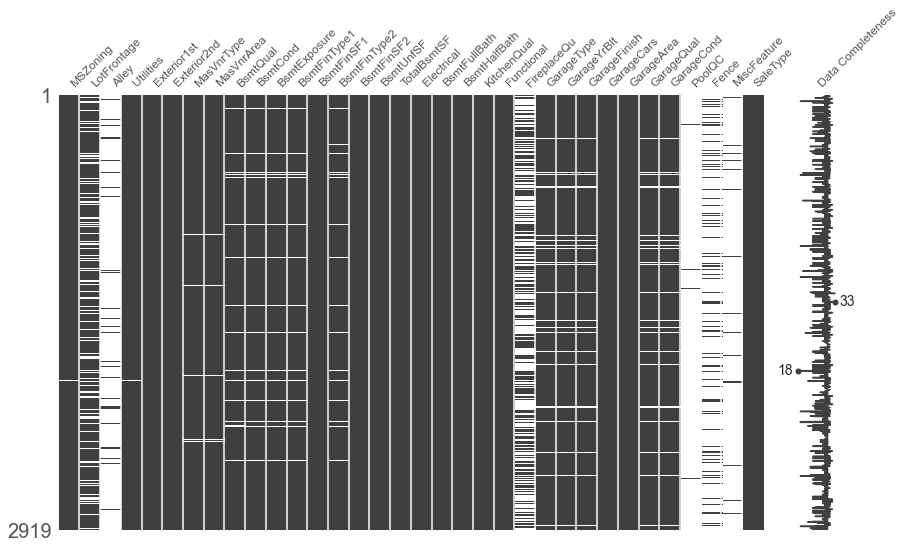

In [108]:
na = (piled_df.isna().sum()[piled_df.isna().sum() > 0]).index
msno.matrix(piled_df.loc[:, na], labels=True, figsize=(14, 8), fontsize=12, inline=False)

 - Assume that Neighborhood and MSZoning are related. The Missing entries in MSZoning can be filed by grouping them with neighborhood and fill those entries. 

In [109]:
Msz_neighbor = (
    piled_df.loc[piled_df["Train"] == 1]
    .groupby(by="Neighborhood")["MSZoning"]
    .agg(pd.Series.mode))

piled_df["MSZoning"] = piled_df["MSZoning"].fillna(
    piled_df["Neighborhood"].map(Msz_neighbor))

 - Assume that KitchenQuality and OverallQuality are interelated. The Missing entries in KitchenQuality can be filed by grouping them with OverallQuatity and fill those entries.

In [110]:
kitchq_overalq = (
    piled_df.loc[piled_df["Train"] == 1]
    .groupby(by="OverallQual")["KitchenQual"]
    .agg(pd.Series.mode))

piled_df["KitchenQual"] = piled_df["KitchenQual"].fillna(
    piled_df["OverallQual"].map(kitchq_overalq))

 - The features in the list `replace_na_with_missing` have entries 'nan', replace that with string `missing`. 

In [111]:
replace_nan_with_missing = {
    "Alley",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinType1",
    "BsmtFullBath",
    "BsmtQual",
    "Fence",
    "FireplaceQu",
    "GarageCond",
    "GarageFinish",
    "GarageQual",
    "GarageType",
    "MasVnrType",
    "MiscFeature",
    "PoolQC",
    "BsmtFinType2",
}
for col in replace_nan_with_missing:
    piled_df[col] = piled_df[col].astype(object).fillna("Missing")

 - The features in the list `replace_na_with_zero` have entries 'nan', replace those entrie with int `0`.

In [112]:
replace_na_with_zero = {
    "GarageArea",
    "GarageCars",
    "TotalBsmtSF",
    "MasVnrArea",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtFullBath",
    "BsmtHalfBath",
    "GarageYrBlt",
}

for col in replace_na_with_zero:
    piled_df[col] = piled_df[col].astype(object).fillna(0)

 - The features in the list `replace_na_with_mode` have entries 'nan', replace those entries with the `mode` of the feature.

In [113]:
replace_na_with_mode = {
    "Functional",
    "Electrical",
    "Utilities",
    "Exterior1st",
    "Exterior2nd",
    "SaleType",
}
for col in replace_na_with_mode:
    piled_df[col] = (
        piled_df[col]
        .astype(object)
        .fillna(piled_df.loc[piled_df["Train"] == 1, col].mode()[0]))

 - We can use a `Sklearn` (scikit-learn) class `IterativeImputer` to impute the rest of the missing values. It performs a multivariate imputation that estimates each feature from all of the others in a 'round-robin' fashion.

In [114]:
features_num = piled_df.drop(columns=["Train"]).select_dtypes("number").columns
impute = IterativeImputer(
    RandomForestRegressor(max_depth=8),
    n_nearest_features=10,
    max_iter=10,
    random_state=random_state,)

piled_df.loc[piled_df["Train"] == 1, features_num] = impute.fit_transform(
    piled_df.loc[piled_df["Train"] == 1, features_num].values)

piled_df.loc[piled_df["Train"] == 0, features_num] = impute.transform(
    piled_df.loc[piled_df["Train"] == 0, features_num].values)

In [115]:
piled_df["WarmSeason"] = np.where(
    piled_df["MoSold"].isin([10, 11, 12, 1, 2, 3]), 0, 1
)
piled_df["SqFtPerRoom"] = piled_df["GrLivArea"] / (
    piled_df["TotRmsAbvGrd"]
    + piled_df["FullBath"]
    + piled_df["HalfBath"]
    + piled_df["KitchenAbvGr"]
)

 - Convert MSSubClass into a categorical feature.

In [116]:
piled_df["MSSubClass"] = piled_df["MSSubClass"].astype(str)

 - Ranking categorical features based on the median SalePrice. 

In [117]:
rank_categories = [
    "BsmtQual",
    "ExterQual",
    "ExterCond",
    "Exterior1st",
    "FireplaceQu",
    "GarageCond",
    "GarageQual",
    "Heating",
    "Fence",
    "HeatingQC",
    "OverallQual",
    "OverallCond",
    "HouseStyle",
    "KitchenQual",
    "LotShape",
    "BsmtCond",
    "MSSubClass",
    "Neighborhood",
    "SaleCondition",
    "SaleType",
    "MasVnrType",
    "ExterQual",
]

for col in rank_categories:
    rank = np.array(
        range(0, len(piled_df.loc[piled_df["Train"] == 1, col].unique()))
    )
    field_val = (
        piled_df.loc[piled_df["Train"] == 1]
        .groupby(by=col)["SalePrice"]
        .median()
        .sort_values()
        .index
    )
    rankval_mapping = dict(zip(field_val, rank))
    piled_df[col + "_ranking"] = piled_df[col].map(
        rankval_mapping, na_action="ignore"
    )

 -  There is a MSSubClass feature in test df but not in train df. This creates an nan entries during ranking. We impute that nan entries with the mode based on the train set.

In [118]:
piled_df.loc[piled_df["MSSubClass_ranking"].isna(), "MSSubClass_ranking"] = 10

# We will combine underrepresented categories under one umbrella and/or with another category in the same field
ext2_map = {"AsphShn": "Oth1", "CBlock": "Oth1", "CmentBd": "Oth2", "Other": "Oth2"}
roofmatl_map = {
    "Roll": "Oth1",
    "ClyTile": "Oth1",
    "Metal": "Oth1",
    "CompShg": "Oth1",
    "Membran": "Oth2",
    "WdShake": "Oth2",
}

cond2_map = {"PosA": "Pos", "PosN": "Pos", "RRAe": "Norm", "RRAn": "Norm"}


piled_df["Exterior2nd"] = (
    piled_df["Exterior2nd"].map(ext2_map).fillna(piled_df["Exterior2nd"])
)
piled_df["RoofMatl"] = (
    piled_df["RoofMatl"].map(roofmatl_map).fillna(piled_df["RoofMatl"])
)
piled_df["Condition2"] = (
    piled_df["Condition2"].map(cond2_map).fillna(piled_df["Condition2"])
)

## Feature Engineering 

In [119]:
piled_df["QualCond"] = (
    piled_df["OverallQual_ranking"] * piled_df["OverallCond_ranking"]
)
piled_df["TotalSF"] = piled_df["1stFlrSF"] + piled_df["2ndFlrSF"]
piled_df["NHoodExtCond"] = (
    piled_df["Neighborhood_ranking"] * piled_df["ExterCond_ranking"]
)
piled_df["NHoodPrivacy"] = (
    piled_df["Neighborhood_ranking"] * piled_df["Fence_ranking"]
)
piled_df["AreaOverallQualCond"] = (
    piled_df["TotalSF"]
    * piled_df["OverallQual_ranking"]
    * piled_df["OverallCond_ranking"]
)
piled_df["KitchenQCTotalSF"] = (
    piled_df["TotalSF"] * piled_df["KitchenQual_ranking"]
)
piled_df["NHoodOverallQual"] = (
    piled_df["Neighborhood_ranking"] * piled_df["OverallQual_ranking"]
)
piled_df["NHoodMasVnrType"] = (
    piled_df["Neighborhood_ranking"] * piled_df["MasVnrType_ranking"]
)
piled_df["NHoodKitchenQual"] = (
    piled_df["Neighborhood_ranking"] * piled_df["KitchenQual_ranking"]
)
piled_df["NHoodCond1"] = piled_df["Neighborhood_ranking"] * piled_df["Condition1"]
piled_df["NHoodCond2"] = piled_df["Neighborhood_ranking"] * piled_df["Condition2"]
piled_df["NHoodPorch"] = piled_df["Neighborhood_ranking"] * (
    piled_df["3SsnPorch"] + piled_df["EnclosedPorch"] + piled_df["OpenPorchSF"]
)

piled_df["Age_YrBuilt"] = piled_df["YrSold"] - piled_df["YearBuilt"]
piled_df["Age_YrRemod"] = piled_df["YrSold"] - piled_df["YearRemodAdd"]
piled_df["Age_Garage"] = piled_df["YrSold"] - piled_df["GarageYrBlt"]
piled_df["Remodeled"] = piled_df["YearBuilt"] != piled_df["YearRemodAdd"]
piled_df["Age_YrBuilt"] = piled_df["Age_YrBuilt"].apply(lambda x: 0 if x < 0 else x)
piled_df["Age_YrRemod"] = piled_df["Age_YrRemod"].apply(lambda x: 0 if x < 0 else x)
piled_df["Age_Garage"] = piled_df["Age_Garage"].apply(lambda x: 0 if x < 0 else x)

sqft_price_table = (
    piled_df.loc[piled_df["Train"] == 1]
    .groupby(by="Neighborhood")["SalePrice", "GrLivArea"]
    .agg(pd.Series.sum)
)
sqft_price_table["AvgPricePerSqFt"] = (
    sqft_price_table["SalePrice"] / sqft_price_table["GrLivArea"]
)
sqft_price_table.drop(columns=["SalePrice", "GrLivArea"], inplace=True)
piled_df["AvgPricePerSqFtPerHood"] = piled_df["Neighborhood"].map(
    sqft_price_table.to_dict()["AvgPricePerSqFt"]
)

 - We will drop a few features that dont perfectly correlate like `GarageYrBlt` , `Utilities` and keep the once that do.

In [120]:
piled_df.drop(columns=["GarageYrBlt", "Utilities"], inplace=True)

 - We will visualize some of the newly constructed features to see their relationship with target.


In [121]:
cols_to_viz = [
    "TotalSF",
    "KitchenQCTotalSF",
    "AreaOverallQualCond",
    "NHoodOverallQual",
    "NHoodMasVnrType",
    "NHoodKitchenQual",
]

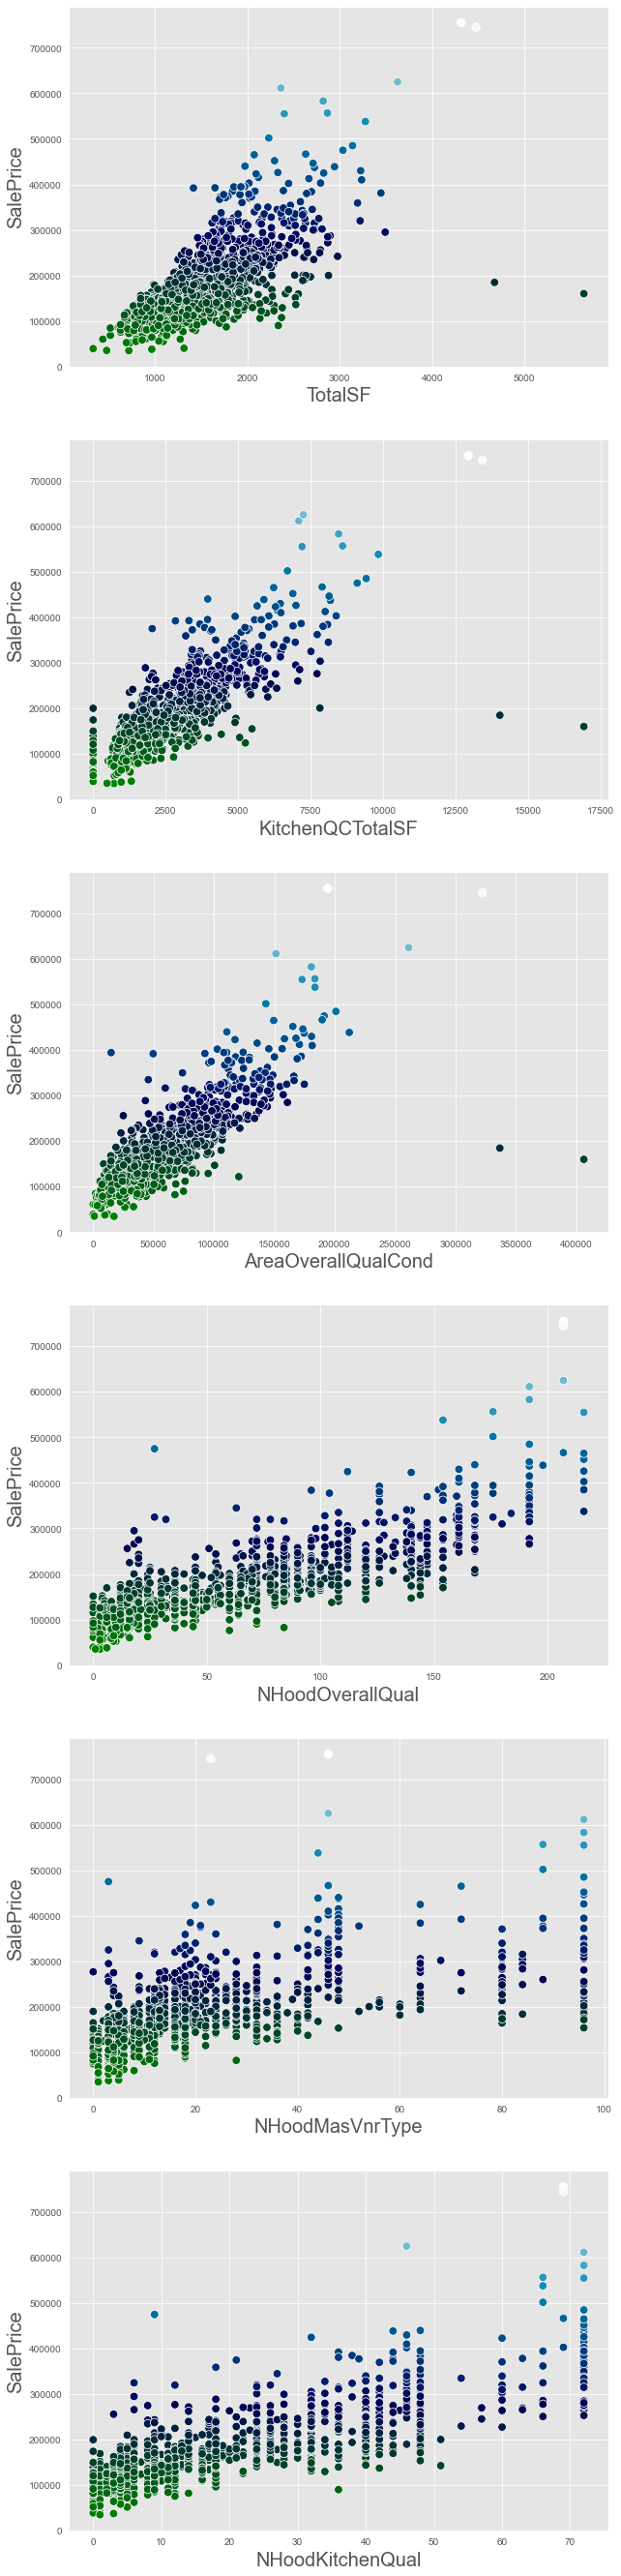

In [122]:
ncols = 1
nrows = math.ceil(len(cols_to_viz) / ncols)
unused = (nrows * ncols) - len(cols_to_viz)


figw, figh = ncols * 10, nrows * 8

fig, ax = plt.subplots(nrows, ncols, sharey=True, figsize=(figw, figh))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
ax = ax.flatten()
for i in range(unused, 0, -1):
    fig.delaxes(ax[-i])


for n, col in enumerate(cols_to_viz):
    if n % 2 != 0:
        ax[n].yaxis.label.set_visible(False)
    ax[n].set_xlabel(col)
    ax[n].set_ylabel("SalePrice")
    sns.scatterplot(
        x=col,
        y="SalePrice",
        data=piled_df.loc[piled_df["Train"] == 1],
        hue="SalePrice",
        palette='ocean',
        s=75,
        legend=False,
        ax=ax[n],
    )

plt.show()

In [123]:
output_notebook()
df_to_viz = piled_df[piled_df["Train"] == 1].drop(columns="Train")

xcorr = abs(df_to_viz.corr())
xcorr.index.name = "Feature1"
xcorr.columns.name = "Feature2"

df = pd.DataFrame(xcorr.stack(), columns=["Corr"]).reset_index()

source = ColumnDataSource(df)

colors = [
    "#75968f",
    "#a5bab7",
    "#c9d9d3",
    "#e2e2e2",
    "#dfccce",
    "#ddb7b1",
    "#cc7878",
    "#933b41",
    "#550b1d",
]

mapper = LinearColorMapper(palette=colors, low=df.Corr.min(), high=df.Corr.max())

f1 = figure(
    plot_width=1500,
    plot_height=1350,
    title="Correlation Heat-Map",
    x_range=list(sorted(xcorr.index)),
    y_range=list(reversed(sorted(xcorr.columns))),
    toolbar_location=None,
    tools="hover",
    x_axis_location="above",
)

f1.rect(
    x="Feature2",
    y="Feature1",
    width=1,
    height=1,
    source=source,
    line_color=None,
    fill_color=transform("Corr", mapper),
)

color_bar = ColorBar(
    color_mapper=mapper,
    location=(0, 0),
    ticker=BasicTicker(desired_num_ticks=len(colors)),
    formatter=PrintfTickFormatter(format="%d%%"),
)
f1.add_layout(color_bar, "right")

f1.hover.tooltips = [
    ("Feature1", "@{Feature1}"),
    ("Feature2", "@{Feature2}"),
    ("Corr", "@{Corr}{1.1111}"),
]

f1.axis.axis_line_color = None
f1.axis.major_tick_line_color = None
f1.axis.major_label_text_font_size = "10px"
f1.axis.major_label_standoff = 2
f1.xaxis.major_label_orientation = 1.0

show(f1)

Loading BokehJS ...

Now let's deal with highly skewned features, if any variable with skewnes larger then 5 will be transformed using yeo-johnson transformation. Which will normalize the feature.

In [124]:
abs(piled_df[piled_df["Train"] == 1].skew()[
    abs(piled_df[piled_df["Train"] == 1].skew()) > 5])

LotArea           12.21
LowQualFinSF       9.01
3SsnPorch         10.30
PoolArea          14.83
MiscVal           24.48
Heating_ranking    9.59
dtype: float64

In [125]:
highly_skewed_cols = (
    piled_df[piled_df["Train"] == 1]
    .skew()[abs(piled_df[piled_df["Train"] == 1].skew()) > 5]
    .index.to_list()
)

ptransformer = PowerTransformer(standardize=False)

piled_df.loc[
    piled_df["Train"] == 1, highly_skewed_cols
] = ptransformer.fit_transform(
    piled_df.loc[piled_df["Train"] == 1, highly_skewed_cols]
)
piled_df.loc[piled_df["Train"] == 0, highly_skewed_cols] = ptransformer.transform(
    piled_df.loc[piled_df["Train"] == 0, highly_skewed_cols]
)

 - `features_bool` is a list for boolean features.
 - `features_catego` is a list for categorical features.
 - `features_num` is a list for numerical features.

In [126]:
features_bool = [
    col
    for col in piled_df.select_dtypes(include=["number"]).columns
    if np.array_equal(
        np.sort(piled_df[col].unique(), axis=0), np.sort([0, 1], axis=0))
]

features_catego = [col for col in piled_df.select_dtypes(exclude=["number"]).columns]
features_num = [
    col
    for col in piled_df.select_dtypes(include=["number"]).columns
    if col not in (features_bool) and col != "SalePrice"]

 - `ohe_cols_a` this list contains features that has the same set of values between train - test.
 - `ohe_cols_b` this list contains features that has different set of values between train - test.

In [127]:
features_bool.remove("Train")
X_train_bool = piled_df.loc[piled_df["Train"] == 1, features_bool]
X_test_bool = piled_df.loc[piled_df["Train"] == 0, features_bool]

ohe_cols_a = []

ohe_cols_b = []

for col in features_catego:
    if set(piled_df.loc[piled_df["Train"] == 1, col].unique()) != set(
        piled_df.loc[piled_df["Train"] == 0, col].unique()
    ):
        ohe_cols_b.append(col)

ohe_cols_a = list(set(features_catego) - set(ohe_cols_b))

In [128]:
ohe_cols_b

['MSSubClass',
 'Condition2',
 'HouseStyle',
 'Exterior1st',
 'Heating',
 'Electrical',
 'BsmtFullBath',
 'GarageQual',
 'PoolQC',
 'MiscFeature',
 'NHoodCond1',
 'NHoodCond2']

- Split our df to train and test. 


In [129]:
X_train = piled_df.loc[piled_df["Train"] == 1].drop(
    labels=["SalePrice", "Train"], axis=1
)
# Applying log transformation to the target variable
y_train = piled_df.loc[piled_df["Train"] == 1, "SalePrice"].apply(np.log)
X_test = piled_df.loc[piled_df["Train"] == 0].drop(
    labels=["SalePrice", "Train"], axis=1)


preprocessor = ColumnTransformer(
    transformers=[
        ("onehota", OneHotEncoder(sparse=False, drop="first"), ohe_cols_a),
        ("onehotb", OneHotEncoder(sparse=False, handle_unknown="ignore"), ohe_cols_b),
        ("scaler", StandardScaler(), features_num),
    ],
    remainder="drop",
)


pipeline = Pipeline(
    [("Preprocessor", preprocessor), 
     ("VarThreshold", VarianceThreshold(0.01))])

X_train_preprocessed = pipeline.fit_transform(X_train)
X_test_preprocessed = pipeline.transform(X_test)

 1. Get the list of one-hot encoded columns and combine them.
 2. Filtering and dropout out the features by variance threshold.
 3. Put back the column names to help with analysis and combine both the df together.

In [130]:
# 1
oh_encoded_a = list(
    preprocessor.named_transformers_.onehota.get_feature_names(ohe_cols_a))

oh_encoded_b = list(
    preprocessor.named_transformers_.onehotb.get_feature_names(ohe_cols_b))

oh_encoded_cols = oh_encoded_a + oh_encoded_b

feature_names = np.array(oh_encoded_cols + features_num, order="K")

feature_names = feature_names[pipeline.named_steps.VarThreshold.get_support()]

# 2
X_train_preprocessed = pd.DataFrame(data=X_train_preprocessed, columns=feature_names)
X_test_preprocessed = pd.DataFrame(data=X_test_preprocessed, columns=feature_names, index=X_test_bool.index)

# 3
X_train = pd.concat([X_train_bool, X_train_preprocessed], axis=1)
X_test = pd.concat([X_test_bool, X_test_preprocessed], axis=1)

#### Feature Importance :
We obtain feature importances using two models(Lasso and premutation) . Lasso seems like a good feature selection model for datasets with high feature, low sample size).
In addition to Lasso, I'll be using sklearn's permutation feature importance model. The pitfall of permutation importance is that it doesn't do the best job when it comes to correlated independent variables. This is something to keep in mind when we're interpreting the results

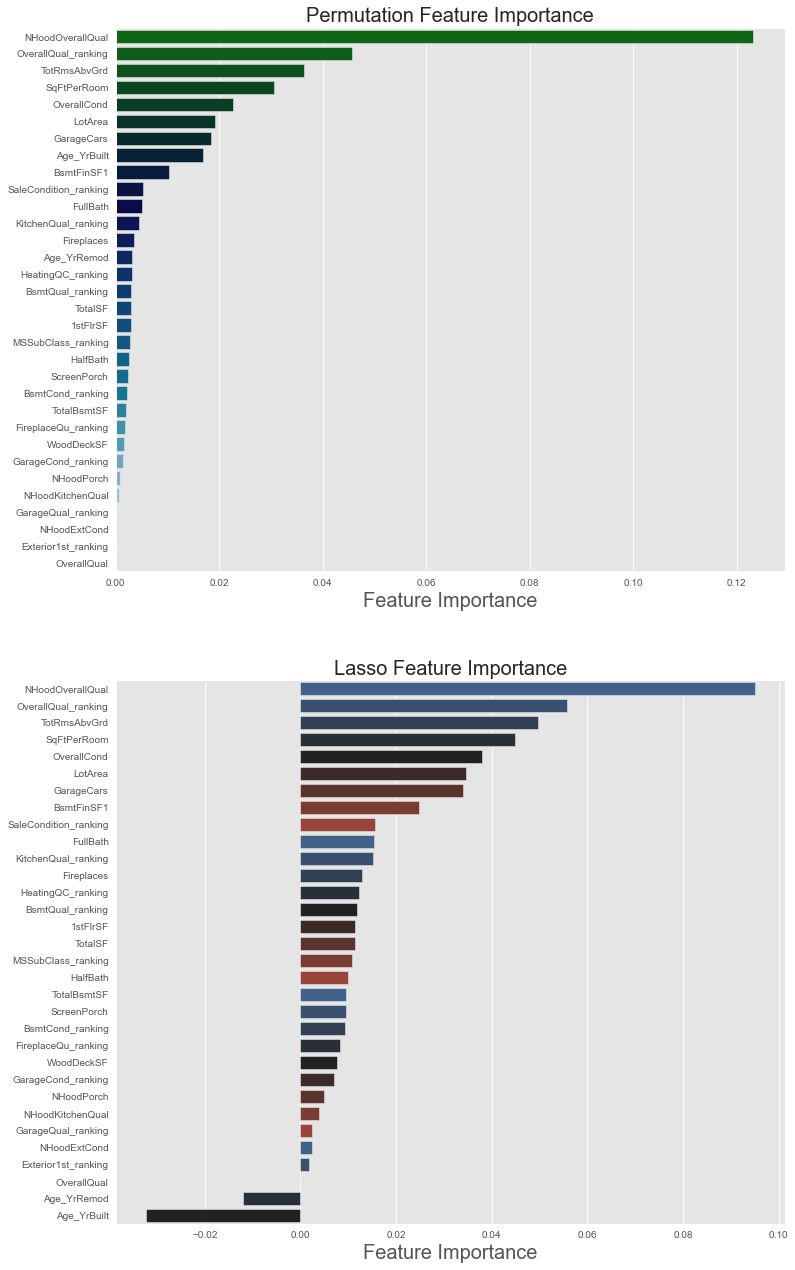

In [131]:
model = Lasso(alpha=0.01)
model.fit(X_train, y_train)


feature_imp = permutation_importance(
    model, X_train, y_train, n_repeats=10, n_jobs=-1, random_state=random_state
)

perm_ft_imp_df = pd.DataFrame(
    data=feature_imp.importances_mean, columns=["Feature Importance"], index=X_train.columns
).sort_values(by="Feature Importance", ascending=False)
model_ft_imp_df = pd.DataFrame(
    data=model.coef_, columns=["Feature Importance"], index=X_train.columns
).sort_values(by="Feature Importance", ascending=False)

fig, ax = plt.subplots(2, 1, figsize=(12, 22))

perm_ft_imp_df_nonzero = perm_ft_imp_df[perm_ft_imp_df["Feature Importance"] != 0]
model_ft_imp_df_nonzero = model_ft_imp_df[model_ft_imp_df["Feature Importance"] != 0]

sns.barplot(
    x=perm_ft_imp_df_nonzero["Feature Importance"],
    y=perm_ft_imp_df_nonzero.index,
    ax=ax[0],
    palette="ocean",
)
sns.barplot(
    x=model_ft_imp_df_nonzero["Feature Importance"],
    y=model_ft_imp_df_nonzero.index,
    ax=ax[1],
    palette=sns.diverging_palette(250, 15, s=75, l=40,
                                  n=9, center="dark"),
)

ax[0].set_title("Permutation Feature Importance")
ax[1].set_title("Lasso Feature Importance")

plt.show()

**Findings:**
- We expected `OverallQual` , `Neighborhood ` , `GrLivArea` and `Year built` to rank high in feature imporatnce. 
- But in controdction newly constructed features like `NHoodOverallQual` , `OverallQuall_ranking` and etc ranked higher in feature imporatance. 

# Part - 3 Fit and Tune a forcasting model, Predection, Score Reporting and Kaggel Ranking

In [79]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from mlxtend.regressor import StackingCVRegressor

In [38]:
param_grid=[{'kernel': ['rbf', 'poly'],
             'C': [0.1, 1, 10],
            'epsilon': [0.005, 0.01, 0.025, 0.05, 0.1],
            'gamma': [0.0001, 0.0005, 0.001, 0.05]
        }]
gsc = GridSearchCV(
        estimator=SVR(),
        param_grid = param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [39]:
%%time
gsc.fit(X_train, y_train)

Wall time: 3min 8s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10],
                          'epsilon': [0.005, 0.01, 0.025, 0.05, 0.1],
                          'gamma': [0.0001, 0.0005, 0.001, 0.05],
                          'kernel': ['rbf', 'poly']}],
             scoring='neg_mean_squared_error')

In [41]:
y_pred = gsc.predict(X_test)

In [42]:
y_pred = np.exp(y_pred)

In [44]:
rf = RandomForestRegressor(criterion = 'mse')

In [45]:
param_grid=[{"max_depth":[6, 7, 8, 9, 10], "max_features":[20, 30, 40, 50, 60], "n_estimators": [100, 125, 150, 175, 200]}]
gsc_rf = GridSearchCV(
        estimator= rf,
        param_grid = param_grid,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [46]:
gsc_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid=[{'max_depth': [6, 7, 8, 9, 10],
                          'max_features': [20, 30, 40, 50, 60],
                          'n_estimators': [100, 125, 150, 175, 200]}],
             scoring='neg_mean_squared_error')

In [47]:
gsc_rf.best_params_

{'max_depth': 10, 'max_features': 40, 'n_estimators': 175}

In [49]:
y_pred = gsc_rf.predict(X_test)

In [50]:
lgbm =  LGBMRegressor()

In [51]:
param_lgb = {
    "boosting_type" :['gbdt','goss','rf'],
    "num_leaves":[12,14,16,18,20,31],
    "max_depth": [-1],
    "n_estimators": [100, 125,143 , 145, 165,250], 
    "learning_rate":[0.01,0.1,0.15,0.125]}

gsc_lgb = GridSearchCV(
        estimator = lgbm,
        param_grid = param_lgb,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [52]:
gsc_lgb.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'goss', 'rf'],
                         'learning_rate': [0.01, 0.1, 0.15, 0.125],
                         'max_depth': [-1],
                         'n_estimators': [100, 125, 143, 145, 165, 250],
                         'num_leaves': [12, 14, 16, 18, 20, 31]},
             scoring='neg_mean_squared_error')

In [53]:
gsc_lgb.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': -1,
 'n_estimators': 145,
 'num_leaves': 14}

In [55]:
y_pred = gsc_lgb.predict(X_test)
y_pred = np.exp(y_pred)

In [56]:
dc = DecisionTreeRegressor()

In [57]:
param_dc = {"criterion": ["mse"],
              "min_samples_split": [10, 20, 40, 60, 80],
              "max_depth": [2, 6, 8, 10, 12, 14, 16],
              "min_samples_leaf": [20, 40, 100, 125, 150],
              "max_leaf_nodes": [5, 20, 100],
              }

In [58]:
gsc_dc = GridSearchCV(estimator = dc,
        param_grid = param_dc,
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [59]:
gsc_dc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'],
                         'max_depth': [2, 6, 8, 10, 12, 14, 16],
                         'max_leaf_nodes': [5, 20, 100],
                         'min_samples_leaf': [20, 40, 100, 125, 150],
                         'min_samples_split': [10, 20, 40, 60, 80]},
             scoring='neg_mean_squared_error')

In [60]:
gsc_dc.best_params_

{'criterion': 'mse',
 'max_depth': 8,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 20,
 'min_samples_split': 40}

In [62]:
y_pred = gsc_dc.predict(X_test)

In [63]:
y_pred = np.exp(y_pred)

In [73]:
lasso = Lasso()
param_lasso = {"alpha" : [0.0004,0.0005,0.0006,0.0007],
              "selection" : ['cyclic', 'random']}

gsc_lasso = GridSearchCV(estimator = lasso,
                        param_grid = param_lasso,
                        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
gsc_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.0004, 0.0005, 0.0006, 0.0007],
                         'selection': ['cyclic', 'random']},
             scoring='neg_mean_squared_error')

In [74]:
gsc_lasso.best_params_

{'alpha': 0.0005, 'selection': 'random'}

In [75]:
svr_params = gsc.best_params_
rf_params = gsc_rf.best_params_
lgb_params = gsc_lgb.best_params_
dc_params = gsc_dc.best_params_
lasso_params = gsc_lasso.best_params_

In [83]:
svr = SVR(**svr_params)
lasso = Lasso(**lasso_params, random_state=random_state)
lgbm = LGBMRegressor(**lgb_params, random_state=random_state)
rf = RandomForestRegressor(**rf_params, random_state=random_state)
dc = DecisionTreeRegressor(**dc_params, random_state=random_state)
stack = StackingCVRegressor(
    regressors=[svr, dc, lasso, lgbm, rf],
    meta_regressor=LinearRegression(n_jobs=-1),
    random_state=random_state,
    cv=5,
    n_jobs=-1,
)

In [84]:
cv = 5
svr_scores = cross_val_score(
    svr, X_train, y_train, cv=cv, n_jobs=-1, error_score="neg_root_mean_squared_error"
)
dc_scores = cross_val_score(
    dc, X_train, y_train, cv=cv, n_jobs=-1, error_score="neg_root_mean_squared_error"
)
lasso_scores = cross_val_score(
    lasso, X_train, y_train, cv=cv, n_jobs=-1, error_score="neg_root_mean_squared_error"
)
lgbm_scores = cross_val_score(
    lgbm, X_train, y_train, cv=cv, n_jobs=-1, error_score="neg_root_mean_squared_error"
)
rf_scores = cross_val_score(
    rf, X_train, y_train, cv=cv, n_jobs=-1, error_score="neg_root_mean_squared_error"
)
stack_scores = cross_val_score(
    stack, X_train, y_train, cv=cv, n_jobs=-1, error_score="neg_root_mean_squared_error"
)



In [85]:
scores = [svr_scores.mean(), dc_scores.mean(), lasso_scores.mean(), lgbm_scores.mean(), rf_scores.mean(), stack_scores.mean()]
models = ["SVR", "dc", "LASSO", "LGBM", "RF", "STACK"]

In [88]:
scores

[0.9137398616721697,
 0.8038273330396812,
 0.8927812351733223,
 0.8991753977402638,
 0.8854574515525865,
 0.9147881841416468]

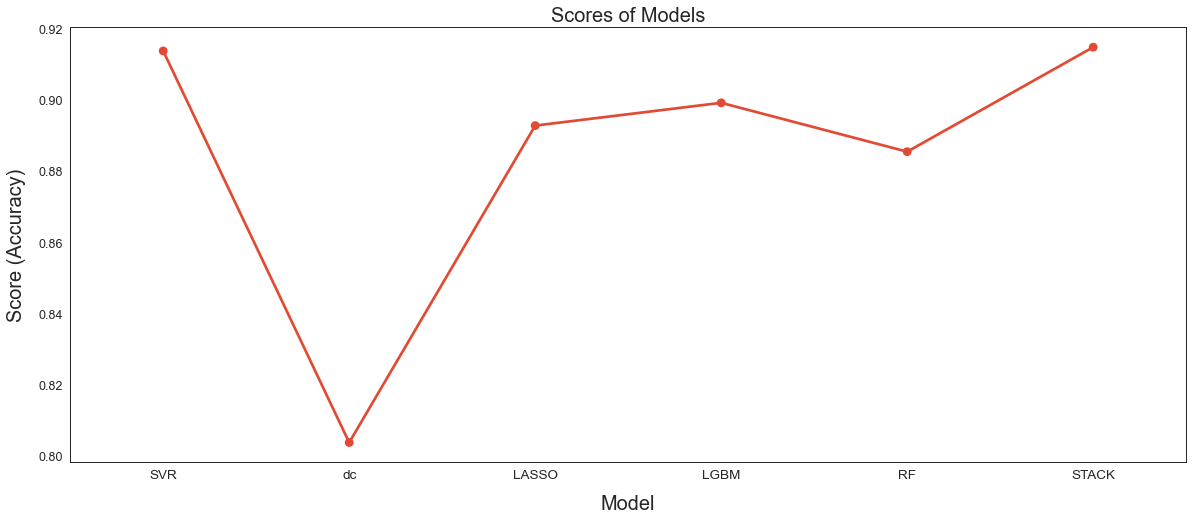

In [91]:
sns.set_style("white")
fig = plt.figure(figsize=(20, 8))

ax = sns.pointplot(x = models, y = scores, markers=['o'], linestyles=['-'])

plt.ylabel('Score (Accuracy)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

In [89]:
stack.fit(X_train, y_train)

StackingCVRegressor(meta_regressor=LinearRegression(n_jobs=-1), n_jobs=-1,
                    random_state=55,
                    regressors=[SVR(C=10, epsilon=0.025, gamma=0.001),
                                DecisionTreeRegressor(max_depth=8,
                                                      max_leaf_nodes=100,
                                                      min_samples_leaf=20,
                                                      min_samples_split=40,
                                                      random_state=55),
                                Lasso(alpha=0.0005, random_state=55,
                                      selection='random'),
                                LGBMRegressor(n_estimators=145, num_leaves=14,
                                              random_state=55),
                                RandomForestRegressor(max_depth=10,
                                                      max_features=40,
                                           

In [137]:
y_pred = stack.predict(X_test.values)
y_pred = np.exp(y_pred)

submission = pd.DataFrame({"Id": Id_submission, "SalePrice": y_pred})
submission.to_csv("submission.csv", index=False)

From the graph, we can clearly see that stacked model performs better than all other models, even though SVR has closest accuracy. Stacked model usually performs better than single models, using stacked model is preferred.

After submiting the predections in the competiton, we got mean square of log sales price as 0.11516 and placing us at 119th position. (6/November/2020 | 3:35PM)

<img src="Kaggel Score.PNG">